In [1]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from powerlaw import Fit
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import median_test
from scipy.stats import ks_2samp
from scipy.stats import levene
import statsmodels.formula.api as smf
from scipy.stats import gaussian_kde

In [2]:
DIR = "/raid5pool/tank/luehring/german_newsguard_tweets/discussions/"
PAPER_DIR = "/home/luehring/emomis/emomis-discussion-paper/"

In [3]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [4]:
df = pd.read_csv(join(DIR, "discussions_complete.csv.gz"),
                            compression="gzip")
df

,conversation_id,id,domain,author_id,created_at,text,reply_count,retweet_count,quote_count,like_count,...,sadness,joy,enthusiasm,pride,hope,out,type,status,Orientation,step
0,1343868571261276160,1343868571261276160,unsere-natur.net,111087017,2020-12-29 10:36:49+00:00,Superkräfte von hoch emphatischen Menschen htt...,0.0,0.0,0.0,0.0,...,0.000517,0.001237,0.002381,0.331691,0.002308,0.023976,starter,complete,Neutral,domain
1,1342017428679766016,1342017428679766016,unsere-natur.net,2659496035,2020-12-24 08:01:03+00:00,Berliner Senat bestätigt staatlichen Corona-Be...,0.0,0.0,0.0,0.0,...,0.000566,0.000506,0.001607,0.000628,0.000810,0.056955,starter,complete,Neutral,domain
2,1339283806256320512,1339283806256320512,unsere-natur.net,982980550402215936,2020-12-16 18:58:36+00:00,"Diese Kinder erleben die Hölle auf Erden, dami...",0.0,0.0,0.0,0.0,...,0.066498,0.002586,0.001033,0.000809,0.000494,0.053378,starter,complete,Neutral,domain
3,1338377122918920193,1338377122918920193,unsere-natur.net,1287356238590881792,2020-12-14 06:55:46+00:00,Karl Lauterbach schämt sich für deutschen Erfi...,0.0,0.0,0.0,0.0,...,0.001774,0.001025,0.000438,0.004230,0.000210,0.024969,starter,complete,Neutral,domain
4,1336753366337286144,1336753366337286144,unsere-natur.net,982980550402215936,2020-12-09 19:23:32+00:00,"Diese Kinder erleben die Hölle auf Erden, dami...",0.0,0.0,0.0,0.0,...,0.066498,0.002586,0.001033,0.000809,0.000494,0.053378,starter,complete,Neutral,domain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19498931,1478388449686212621,1478392757177786372,NaN,3338852519,2022-01-04 15:47:55+00:00,@KramerSimeon @FCAugsburg @VfB Dann nimm meine...,0.0,0.0,0.0,1.0,...,0.001158,0.003647,0.000923,0.000778,0.000308,0.051909,reply,complete,NaN,conversation
19498932,1478388449686212621,1478391129192153093,NaN,1301448293935910912,2022-01-04 15:41:27+00:00,@VfBWallaceFan @FCAugsburg @VfB Den Artikel ge...,1.0,0.0,0.0,1.0,...,0.000620,0.000942,0.004218,0.001348,0.000617,0.019331,reply,complete,NaN,conversation
19498933,1478388449686212621,1478389975125307392,NaN,3338852519,2022-01-04 15:36:51+00:00,"@KramerSimeon @FCAugsburg @VfB ""Schaut nur zu""...",1.0,0.0,0.0,0.0,...,0.001209,0.002308,0.000838,0.000434,0.000518,0.214049,reply,complete,NaN,conversation
19498934,1478388449686212621,1478388449686212621,zvw.de,1301448293935910912,2022-01-04 15:30:48+00:00,Während die Konkurrenz wie der @FCAugsburg auf...,6.0,0.0,0.0,4.0,...,0.000525,0.000295,0.001830,0.000523,0.000280,0.033290,starter,complete,Neutral,domain


In [5]:
len(df)

19498936

In [6]:
df["type"].value_counts()

reply      10831242
starter     8667694
Name: type, dtype: int64

In [7]:
starter = df[df["type"] == "starter"]

In [8]:
misinfo_starter = starter[starter["Rating"] == "N"]
len(misinfo_starter)

534855

In [9]:
# number of conversations
misinfo_starter["Rating"].value_counts()

N    534855
Name: Rating, dtype: int64

In [10]:
# number of conversations
misinfo_starter["conversation_id"].nunique(), misinfo_starter["id"].nunique()

(530624, 530624)

In [11]:
replies = df[df["type"] == "reply"] #only replies
len(replies)

10831242

In [12]:
n_all_users = replies["author_id"].nunique() # n_users in only replies
n_all_users

395579

In [13]:
# extract replies from df
misinfo_replies = replies[replies["conversation_id"].isin(misinfo_starter["conversation_id"])]
len(misinfo_replies)

413084

In [14]:
misinfo_replies["author_id"].nunique()

43975

In [15]:
# how many misinfo conversations?
misinfo_replies["conversation_id"].nunique()

38729

In [16]:
# what is the total number of replies?
len(misinfo_replies)

413084

In [17]:
# how many unique users?
misinfo_replies["author_id"].nunique()

43975

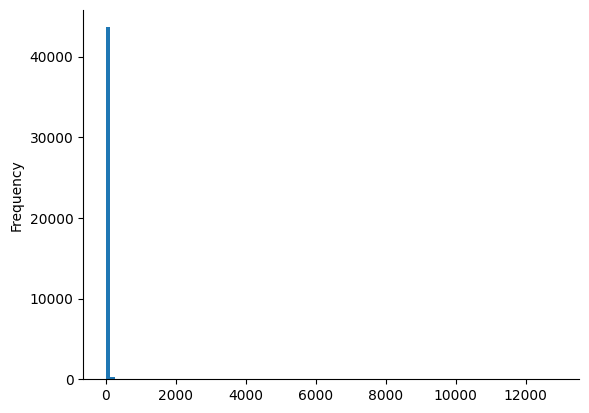

In [18]:
# count frequency of author_id
misinfo_replies["author_id"].value_counts().plot.hist(bins=100)
custom_plots()

## Untrustworthy sources

In [19]:
def summarize_authors(df, n_all_users):
    n_users = df["author_id"].nunique()
    n_discussions = df["conversation_id"].nunique()
    n_replies = len(df)

    author_freq = df["author_id"]\
                    .value_counts()\
                    .reset_index()\
                    .rename(
                        columns={
                            "index": "author_id",
                            "author_id": "n_replies"})


    # calculate percentage of replies per user
    author_freq["replies_perc"] = author_freq["n_replies"] / n_replies * 100


    # calculate cumulative percentage
    author_freq = author_freq.sort_values("n_replies", ascending=False)
    author_freq["cum_replies"] = author_freq["n_replies"].cumsum()
    author_freq["cum_perc"] = author_freq["cum_replies"] / n_replies * 100

    # keep users until X% of the replies
    users_for_90 = (author_freq["cum_perc"] <= 90).sum()
    users_for_80 = (author_freq["cum_perc"] <= 80).sum()
    users_for_70 = (author_freq["cum_perc"] <= 70).sum()

    # calculate percentage of users
    p_90 = users_for_90 / n_all_users * 100
    p_80 = users_for_80 / n_all_users * 100
    p_70 = users_for_70 / n_all_users * 100

    # create a df in long format
    summary = pd.DataFrame({
                            "n_discussions": n_discussions,
                            "n_replies": n_replies,
                            "n_all_users": n_all_users,
                            "n_users": n_users,
                            "users_for_90": users_for_90,
                            "users_for_80": users_for_80,
                            "users_for_70": users_for_70,
                            "p_90": p_90,
                            "p_80": p_80,
                            "p_70": p_70},
                            index=[0])

    return summary

misinfo_summary = summarize_authors(misinfo_replies, n_all_users)
misinfo_summary

,n_discussions,n_replies,n_all_users,n_users,users_for_90,users_for_80,users_for_70,p_90,p_80,p_70
0,38729,413084,395579,43975,15991,8241,4685,4.042429,2.083275,1.18434


## Trustworthy sources

In [20]:
trust_starter = starter[starter["Rating"] == "T"]
len(trust_starter), len(starter)

(8109064, 8667694)

In [21]:
# extract replies from df
trust_replies = replies[replies["conversation_id"].isin(trust_starter["conversation_id"])]
len(trust_replies)

10420313

<Axes: ylabel='Frequency'>

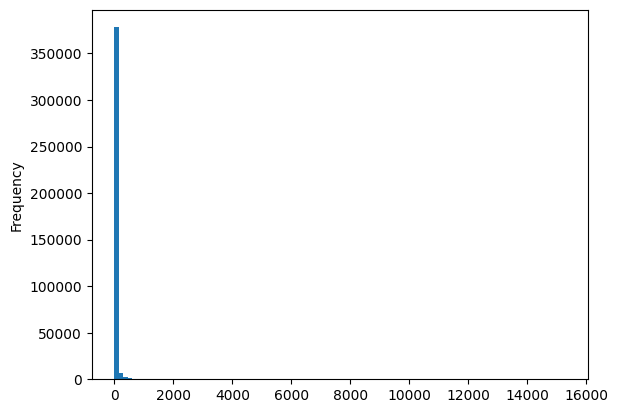

In [22]:
# count frequency of author_id
trust_replies["author_id"].value_counts().plot.hist(bins=100)

In [23]:
trust_summary = summarize_authors(trust_replies, n_all_users)
trust_summary

,n_discussions,n_replies,n_all_users,n_users,users_for_90,users_for_80,users_for_70,p_90,p_80,p_70
0,813735,10420313,395579,391943,76579,37958,21976,19.358712,9.595555,5.555401


## Total sources

In [24]:
total_summary = summarize_authors(replies, n_all_users)
total_summary

,n_discussions,n_replies,n_all_users,n_users,users_for_90,users_for_80,users_for_70,p_90,p_80,p_70
0,852326,10831242,395579,395579,75975,37646,21821,19.206025,9.516683,5.516218


In [25]:
# merge misinfo_summary and trust_summary 
summary = pd.concat([misinfo_summary, trust_summary], axis=0)
summary["Source"] = ["Untrustworthy", "Trustworthy"]

In [26]:

summary = pd.concat([misinfo_summary, trust_summary], axis=0)
summary["Source"] = ["Untrustworthy", "Trustworthy"]

# Compute percentages
summary["p_users"] = summary["n_users"] / summary["n_all_users"] * 100
summary["p_discussions"] = summary["n_discussions"] / summary["n_discussions"].sum() * 100
summary["p_replies"] = summary["n_replies"] / summary["n_replies"].sum() * 100

# Add the Total row **before formatting**
summary = pd.concat([summary, total_summary], axis=0)
summary["Source"] = ["Untrustworthy", "Trustworthy", "Total"]

# Ensure all relevant columns are numeric before formatting
comma_cols = ["n_discussions", "n_replies", "n_all_users", "n_users", "users_for_90", "users_for_80", "users_for_70"]
summary[comma_cols] = summary[comma_cols].apply(pd.to_numeric, errors='coerce')

# Apply comma formatting **only for the first two rows (excluding Total)**
summary.loc[:1, comma_cols] = summary.loc[:1, comma_cols].applymap(lambda x: f"{x:,.0f}" if pd.notna(x) else "N/A")

# Format numbers with percentages
summary["n_users"] = summary["n_users"].astype(str) + " (" + summary["p_users"].round(1).astype(str) + "%)"
summary["n_discussions"] = summary["n_discussions"].astype(str) + " (" + summary["p_discussions"].round(1).astype(str) + "%)"
summary["n_replies"] = summary["n_replies"].astype(str) + " (" + summary["p_replies"].round(1).astype(str) + "%)"

# Format user breakdown percentages
summary["users_for_90"] = summary["users_for_90"].astype(str) + " (" + summary["p_90"].round(1).astype(str) + "%)"
summary["users_for_80"] = summary["users_for_80"].astype(str) + " (" + summary["p_80"].round(1).astype(str) + "%)"
summary["users_for_70"] = summary["users_for_70"].astype(str) + " (" + summary["p_70"].round(1).astype(str) + "%)"

# Drop unnecessary percentage columns
summary = summary.drop(columns=["p_90", "p_80", "p_70", "p_users", "p_discussions", "p_replies", "n_all_users"])

summary = summary.applymap(lambda x: x.replace("(nan%)", ""))
summary

,n_discussions,n_replies,n_users,users_for_90,users_for_80,users_for_70,Source
0,"38,729 (4.5%)","413,084 (3.8%)","43,975 (11.1%)","15,991 (4.0%)","8,241 (2.1%)","4,685 (1.2%)",Untrustworthy
0,"813,735 (95.5%)","10,420,313 (96.2%)","391,943 (99.1%)","76,579 (19.4%)","37,958 (9.6%)","21,976 (5.6%)",Trustworthy
0,"852,326","10,831,242","395,579","75,975 (19.2%)","37,646 (9.5%)","21,821 (5.5%)",Total


In [27]:
# into long format with Source as the only column not to be melted
summary_long = pd.melt(summary, id_vars=["Source"], var_name="N", value_name="Value")
user_table = summary_long.pivot(index="N", columns="Source", values="Value").reset_index()
user_table.columns.name = None  # Remove the hierarchical column name

# reorder columns
user_table = user_table[["N", "Untrustworthy", "Trustworthy", "Total"]]
user_table.columns = ["N", "Untrustworthy", "Trustworthy", "Total"]

# rename N variables
user_table["N"] = user_table["N"]\
        .str.replace("n_", "")\
        .str.replace("_for_", " (")\
        .str.replace("0", "0%)")\
        .str.capitalize()
user_table

,N,Untrustworthy,Trustworthy,Total
0,Discussions,"38,729 (4.5%)","813,735 (95.5%)","852,326"
1,Replies,"413,084 (3.8%)","10,420,313 (96.2%)","10,831,242"
2,Users,"43,975 (11.1%)","391,943 (99.1%)","395,579"
3,Users (70%),"4,685 (1.2%)","21,976 (5.6%)","21,821 (5.5%)"
4,Users (80%),"8,241 (2.1%)","37,958 (9.6%)","37,646 (9.5%)"
5,Users (90%),"15,991 (4.0%)","76,579 (19.4%)","75,975 (19.2%)"


In [28]:
# save as latex table
# replace all % with \%
user_table_latex = user_table.replace("%", "\\%", regex=True)
user_table_latex

,N,Untrustworthy,Trustworthy,Total
0,Discussions,"38,729 (4.5\%)","813,735 (95.5\%)","852,326"
1,Replies,"413,084 (3.8\%)","10,420,313 (96.2\%)","10,831,242"
2,Users,"43,975 (11.1\%)","391,943 (99.1\%)","395,579"
3,Users (70\%),"4,685 (1.2\%)","21,976 (5.6\%)","21,821 (5.5\%)"
4,Users (80\%),"8,241 (2.1\%)","37,958 (9.6\%)","37,646 (9.5\%)"
5,Users (90\%),"15,991 (4.0\%)","76,579 (19.4\%)","75,975 (19.2\%)"


In [29]:
user_table_latex.to_latex(join(DIR, "user_table.tex"), index=False, escape=False)
user_table_latex.to_latex(join(PAPER_DIR, "tables/", "user_table.tex"), index=False, escape=False)

/tmp/ipykernel_3929320/2339542786.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  user_table_latex.to_latex(join(DIR, "user_table.tex"), index=False, escape=False)
/tmp/ipykernel_3929320/2339542786.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  user_table_latex.to_latex(join(PAPER_DIR, "tables/", "user_table.tex"), index=False, escape=False)


## Within-group differences

In [30]:
def def_cum_replies(df):
    author_freq = df["author_id"]\
                    .value_counts()\
                    .reset_index()\
                    .rename(
                        columns={
                            "index": "author_id",
                            "author_id": "n_replies"})
    author_freq = author_freq.sort_values("n_replies", ascending=False)
    author_freq["cum_replies"] = author_freq["n_replies"].cumsum()
    author_freq["cum_perc"] = author_freq["cum_replies"] / len(df) * 100

    author_cum_replies = author_freq["cum_perc"].values
    cutoff = np.argmax(author_cum_replies >= 80)

    return author_freq, cutoff 

misinfo_users, misinfo_cutoff = def_cum_replies(misinfo_replies)
trust_users, trust_cutoff = def_cum_replies(trust_replies)
all_users, all_cutoff = def_cum_replies(replies)

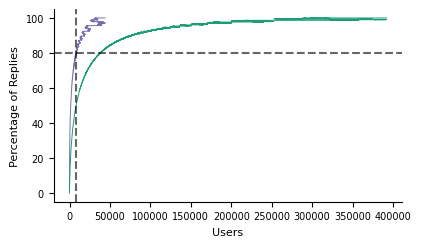

In [31]:
plt.figure(figsize=(4.5, 2.5))
plt.plot(misinfo_users["cum_perc"], label="Untrustworthy", color="#7570b3",
            linewidth=0.7)  
plt.plot(trust_users["cum_perc"], label="Trustworthy", color="#1b9e77",
            linewidth=0.7)

plt.axhline(80, color="black", linestyle="--", alpha=0.6)
plt.axvline(misinfo_cutoff, color="black", linestyle="--", alpha=0.6)

plt.xlabel("Users", fontsize=8)
plt.ylabel("Percentage of Replies", fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)

custom_plots()

plt.show()

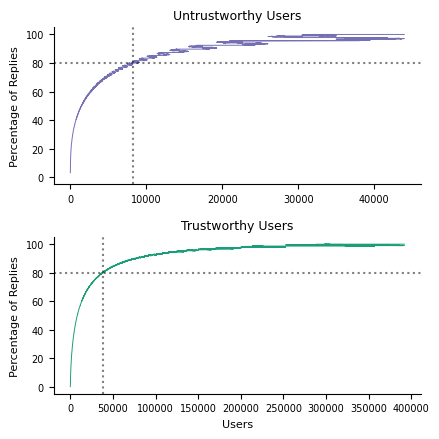

In [32]:
colors = {'Trustworthy': '#1b9e77', 'Untrustworthy': '#7570b3'}

fig, axs = plt.subplots(2, 1, figsize=(4.5, 4.5), sharey=True)

axs[0].plot(misinfo_users["cum_perc"], label="Untrustworthy", color=colors['Untrustworthy'], linewidth=0.7)
axs[0].axhline(80, color="black", linestyle=":", alpha=0.5)
axs[0].axvline(misinfo_cutoff, color="black", linestyle=":", alpha=0.5)
axs[0].set_ylabel("Percentage of Replies", fontsize=8)
axs[0].tick_params(axis='both', which='major', labelsize=7)
axs[0].set_title("Untrustworthy Users", fontsize=9)
custom_plots(axs[0])

axs[1].plot(trust_users["cum_perc"], label="Trustworthy", color=colors['Trustworthy'], linewidth=0.7)
axs[1].axhline(80, color="black", linestyle=":", alpha=0.5)
axs[1].axvline(trust_cutoff, color="black", linestyle=":", alpha=0.5)
axs[1].set_xlabel("Users", fontsize=8)
axs[1].set_ylabel("Percentage of Replies", fontsize=8)
axs[1].tick_params(axis='both', which='major', labelsize=7)
axs[1].set_title("Trustworthy Users", fontsize=9)
custom_plots(axs[1])

fig.tight_layout()

plt.show()

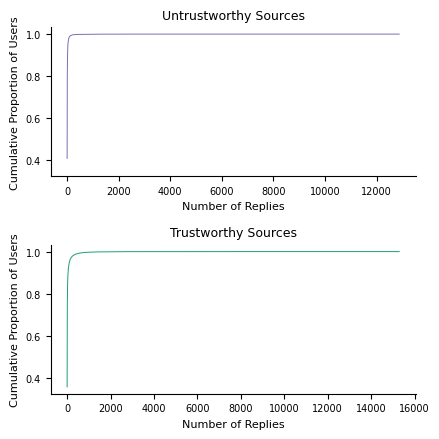

In [33]:
def prep_cdf(df):
    data_counts = df["n_replies"]
    values, counts = np.unique(data_counts, return_counts=True)  # Unique values and their counts
    cumulative_counts = np.cumsum(counts)  # Cumulative sum
    cdf = cumulative_counts / cumulative_counts[-1]  # Normalize to range [0, 1]
    return values, cdf

misinfo_counts, misinfo_cdf = prep_cdf(misinfo_users)
true_counts, true_cdf = prep_cdf(trust_users)


fig, axs = plt.subplots(2, 1, figsize=(4.5, 4.5), sharey=True)

axs[0].plot(misinfo_counts, misinfo_cdf, label="Untrustworthy", color=colors['Untrustworthy'], linewidth=0.7)
axs[0].set_xlabel("Number of Replies", fontsize=8)
axs[0].set_ylabel("Cumulative Proportion of Users", fontsize=8)
axs[0].tick_params(axis='both', which='major', labelsize=7)
axs[0].set_title("Untrustworthy Sources", fontsize=9)
custom_plots(axs[0])

axs[1].plot(true_counts, true_cdf, color=colors['Trustworthy'], linewidth=0.7)
axs[1].set_xlabel("Number of Replies", fontsize=8)
axs[1].set_ylabel("Cumulative Proportion of Users", fontsize=8)
axs[1].tick_params(axis='both', which='major', labelsize=7)
axs[1].set_title("Trustworthy Sources", fontsize=9)
custom_plots(axs[1])

fig.tight_layout()

plt.show()

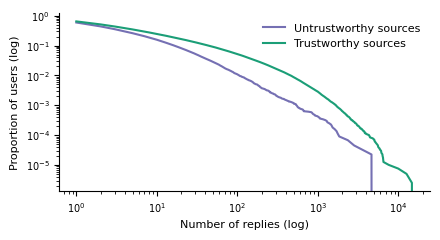

In [34]:
misinfo_ccdf = 1 - misinfo_cdf
trust_ccdf = 1 - true_cdf
# fit_untrustworthy = Fit(misinfo_users["n_replies"], xmin=1) 
# alpha_untrustworthy = fit_untrustworthy.power_law.alpha
# fit_trustworthy = Fit(trust_users["n_replies"], xmin=1)
# alpha_trustworthy = fit_trustworthy.power_law.alpha

plt.figure(figsize=(4.5, 2.5))

plt.loglog(misinfo_counts, misinfo_ccdf, label="Untrustworthy sources", color=colors['Untrustworthy'])
plt.loglog(true_counts, trust_ccdf, label="Trustworthy sources", color=colors['Trustworthy'])
plt.xlabel("Number of replies (log)", fontsize=8)
plt.ylabel("Proportion of users (log)", fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.legend(frameon=False, fontsize=8)

# plt.text(0.35, 0.6, f"α = {alpha_untrustworthy:.2f}", 
#          fontsize=8, transform=plt.gca().transAxes, color=colors['Untrustworthy'])
# plt.text(0.7, 0.6, f"α = {alpha_trustworthy:.2f}", 
#          fontsize=8, transform=plt.gca().transAxes, color=colors['Trustworthy'])

custom_plots()

plt.tight_layout()

#save figure
plt.savefig("reply_cumul_distribution.pdf", dpi=300)
plt.savefig(join(PAPER_DIR, "figures", "reply_cumul_distribution.pdf"), dpi=300)
plt.show()

In [35]:
# split the data into two user groups based on 80% cutoff
misinfo_80 = misinfo_users[misinfo_users["cum_perc"] <= 80]
misinfo_20 = misinfo_users[misinfo_users["cum_perc"] > 80]

trust_80 = trust_users[trust_users["cum_perc"] <= 80]
trust_20 = trust_users[trust_users["cum_perc"] > 80]

# number of users per group as df
users_80 = pd.DataFrame({
    "Untrustworthy": misinfo_80["author_id"].nunique(),
    "Trustworthy": trust_80["author_id"].nunique()
}, index=["80% of replies"])

users_20 = pd.DataFrame({
    "Untrustworthy": misinfo_20["author_id"].nunique(),
    "Trustworthy": trust_20["author_id"].nunique()
}, index=["20% of replies"])


user_thresholds = pd.concat([users_80, users_20], axis=0)
user_thresholds

,Untrustworthy,Trustworthy
80% of replies,8241,37958
20% of replies,35734,353985


In [36]:
misinfo_replies["Extreme"] = misinfo_replies["author_id"].isin(misinfo_80["author_id"])
misinfo_replies["Extreme"].value_counts()

/tmp/ipykernel_3929320/63295522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_replies["Extreme"] = misinfo_replies["author_id"].isin(misinfo_80["author_id"])


True     330467
False     82617
Name: Extreme, dtype: int64

In [37]:
extreme = misinfo_replies[misinfo_replies["Extreme"]]
non_extreme = misinfo_replies[~misinfo_replies["Extreme"]]

len(extreme), len(non_extreme)

(330467, 82617)

In [38]:
# summarize mean 
extreme["anger"].mean(), non_extreme["anger"].mean()

(0.4010955979338365, 0.4083915554355861)

In [39]:
extreme["anger"].std(), non_extreme["anger"].std()

(0.4361774845424079, 0.4368156228707417)

In [40]:
# summarize median 
extreme["anger"].median(), non_extreme["anger"].median()

(0.1046499237418174, 0.1237523108720779)

In [41]:
# mann whitney test
U1, p = mannwhitneyu(extreme["anger"], non_extreme["anger"])

print(f"U = {U1:.0f}, p = {p:.4f}")


U = 13452029422, p = 0.0000


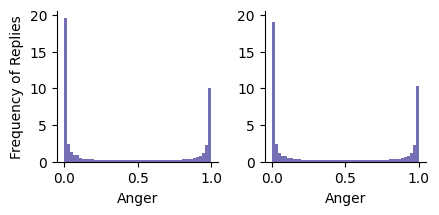

In [42]:
# two histgrams next to each other
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.25), sharey=True)

extreme["anger"].plot.hist(ax=axs[0], bins=50, color=colors['Untrustworthy'], density=True)
axs[0].set_xlabel("Anger")
axs[0].set_ylabel("Frequency of Replies")
custom_plots(axs[0])

non_extreme["anger"].plot.hist(ax=axs[1], 
                               bins=50, 
                               color=colors['Untrustworthy'], 
                               density=True)
axs[1].set_xlabel("Anger")
custom_plots(axs[1])

plt.tight_layout()
plt.show()

In [43]:
# aggregate anger per user
extreme_agg = extreme.groupby("author_id")["anger"].mean()
non_extreme_agg = non_extreme.groupby("author_id")["anger"].mean()

extreme_agg.mean(), non_extreme_agg.mean()

(0.41116300982005305, 0.410634903054157)

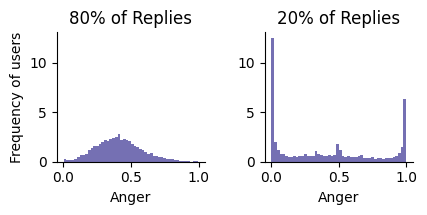

In [44]:
# two histgrams next to each other
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.25), sharey=True)

extreme_agg.plot.hist(ax=axs[0], bins=50, color=colors['Untrustworthy'], density=True)
axs[0].set_xlabel("Anger")
axs[0].set_ylabel("Frequency of users")
axs[0].set_title("80% of Replies")

custom_plots(axs[0])

non_extreme_agg.plot.hist(ax=axs[1], bins=50, color=colors['Untrustworthy'], density=True)
axs[1].set_xlabel("Anger")
axs[1].set_title("20% of Replies")
custom_plots(axs[1])

plt.tight_layout()
plt.show()

In [45]:
extreme_agg.median(), non_extreme_agg.median()

(0.40276275154610625, 0.3519797166809439)

In [46]:
U1, p = mannwhitneyu(extreme_agg, non_extreme_agg)

print(f"U = {U1}, p = {p:.5f}")

U = 159202283.5, p = 0.00000


In [47]:
stat, p, med, table = median_test(extreme_agg, non_extreme_agg)
print(f"Median Test: statistic={stat}, p-value={p:.5f}")

Median Test: statistic=194.8134926457, p-value=0.00000


In [48]:
# t-test with weights
extreme_agg = extreme.groupby("author_id")["anger"].mean()
non_extreme_agg = non_extreme.groupby("author_id")["anger"].mean()

extreme_weights = extreme.groupby("author_id")["anger"].count() / extreme["anger"].count()
non_extreme_weights = non_extreme.groupby("author_id")["anger"].count() / non_extreme["anger"].count()

weighted_extreme_agg = extreme_agg * extreme_weights
weighted_non_extreme_agg = non_extreme_agg * non_extreme_weights

extreme_weighted_mean = weighted_extreme_agg.sum()
non_extreme_weighted_mean = weighted_non_extreme_agg.sum()

extreme_weighted_mean, non_extreme_weighted_mean

(0.4010955979338364, 0.4083915554355861)

## Filter out inactive users

In [49]:
misinfo_authors = misinfo_replies["author_id"]\
                    .value_counts()\
                    .reset_index()\
                    .rename(
                        columns={
                            "index": "author_id",
                            "author_id": "n_replies"})

n_replies = misinfo_authors["n_replies"].sum()  

# calculate percentage of replies per user
misinfo_authors["replies_perc"] = misinfo_authors["n_replies"] / n_replies * 100

# calculate cumulative percentage
misinfo_authors = misinfo_authors.sort_values("n_replies", ascending=False)
misinfo_authors["cum_replies"] = misinfo_authors["n_replies"].cumsum()
misinfo_authors["cum_perc"] = misinfo_authors["cum_replies"] / n_replies * 100
misinfo_authors.head(20)

,author_id,n_replies,replies_perc,cum_replies,cum_perc
0,186813764,12880,3.118010,12880,3.118010
1,1373293126916395008,4644,1.124227,17524,4.242236
2,3092309687,2827,0.684364,20351,4.926601
3,1381276005566971904,2360,0.571312,22711,5.497913
4,1360223452532244481,1847,0.447125,24558,5.945038
5,1308653501849968641,1765,0.427274,26323,6.372312
6,1352351738347577346,1710,0.413959,28033,6.786271
7,236457055,1623,0.392898,29656,7.179169
8,68757774,1526,0.369416,31182,7.548586
9,1240560768552251392,1493,0.361428,32675,7.910013


In [50]:
misinfo_authors = misinfo_authors.merge(
                                misinfo_replies\
                                    .groupby("author_id")["anger"]\
                                        .mean()\
                                            .reset_index(),
                               on="author_id",
                               how="left")
misinfo_authors

,author_id,n_replies,replies_perc,cum_replies,cum_perc,anger
0,186813764,12880,3.118010,12880,3.118010,0.351522
1,1373293126916395008,4644,1.124227,17524,4.242236,0.242273
2,3092309687,2827,0.684364,20351,4.926601,0.376511
3,1381276005566971904,2360,0.571312,22711,5.497913,0.460268
4,1360223452532244481,1847,0.447125,24558,5.945038,0.267800
...,...,...,...,...,...,...
43970,363067577,1,0.000242,413080,99.999032,0.003301
43971,1247167064139124736,1,0.000242,413081,99.999274,0.996533
43972,1473082761732935682,1,0.000242,413082,99.999516,0.027960
43973,853274242359713792,1,0.000242,413083,99.999758,0.003913


In [51]:
# split the data into two user groups based on 80% cutoff
active_misinfo_80 = misinfo_authors[misinfo_authors["cum_perc"] <= 80]
active_misinfo_20 = misinfo_authors[misinfo_authors["cum_perc"] > 80]
# filter out users with less than 5 replies
active_misinfo_20 = active_misinfo_20[active_misinfo_20["n_replies"] >= 5]

In [52]:
active_misinfo_80["anger"].mean(), active_misinfo_20["anger"].mean()

(0.41116300982005305, 0.40863205277842846)

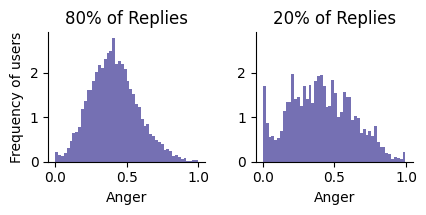

In [53]:
# two histgrams next to each other
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.25), sharey=True)

active_misinfo_80["anger"].plot.hist(ax=axs[0], bins=50, 
                             color=colors['Untrustworthy'], 
                             density=True
                             )
axs[0].set_xlabel("Anger")
axs[0].set_ylabel("Frequency of users")
axs[0].set_title("80% of Replies")

custom_plots(axs[0])

active_misinfo_20["anger"].plot.hist(ax=axs[1], bins=50, 
                                 color=colors['Untrustworthy'], 
                                 density=True
                                 )
axs[1].set_xlabel("Anger")
axs[1].set_title("20% of Replies")
custom_plots(axs[1])

plt.tight_layout()
plt.show()

In [54]:
# levenes test
stat, p = levene(active_misinfo_80["anger"], active_misinfo_20["anger"])
print(f"Levene's Test: statistic={stat:.2f}, p-value={p:.5f}")

Levene's Test: statistic=561.34, p-value=0.00000


In [55]:
# mann whitney test
U1, p = mannwhitneyu(active_misinfo_80["anger"], active_misinfo_20["anger"])
print(f"U = {U1:.0f}, p = {p:.5f}")

U = 20383523, p = 0.15192


In [56]:
# median test
stat, p, med, table = median_test(active_misinfo_80["anger"], active_misinfo_20["anger"])
print(f"Median Test: statistic={stat}, p-value={p:.5f}")

Median Test: statistic=0.9043626250278075, p-value=0.34161


In [57]:
# Perform K-S test
stat, p_value = ks_2samp(active_misinfo_80["anger"], active_misinfo_20["anger"])

print(f"K-S Test Statistic: {stat}")
print(f"P-value: {p_value:.5f}")

K-S Test Statistic: 0.10190477997235217
P-value: 0.00000


In [58]:
# perform Anderson-Darling test
result = stats.anderson_ksamp([active_misinfo_80["anger"], active_misinfo_20["anger"]])

print(f"A-D Test Statistic: {result.statistic}")
print(f"P-value: {result.significance_level}")

A-D Test Statistic: 125.45123382937375
P-value: 0.001


/tmp/ipykernel_3929320/367238350.py:2: UserWarning: p-value floored: true value smaller than 0.001
  result = stats.anderson_ksamp([active_misinfo_80["anger"], active_misinfo_20["anger"]])


## Split into three groups

In [59]:
misinfo_authors["cum_activity"] = pd.cut(misinfo_authors["cum_perc"],
                                        bins=[0, 80, 90, float('inf')],
                                        labels=["high", "medium", "low"])

low_users = misinfo_authors[misinfo_authors["cum_activity"] == "low"]
medium_users = misinfo_authors[misinfo_authors["cum_activity"] == "medium"]
high_users = misinfo_authors[misinfo_authors["cum_activity"] == "high"]

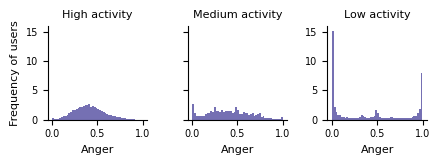

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(4.5, 1.75), 
                        sharey=True
                        )

high_users["anger"].plot.hist(ax=axs[0], bins=50,
                            color=colors['Untrustworthy'], 
                            density=True
                            )
axs[0].set_xlabel("Anger", fontsize=8)
axs[0].set_ylabel("Frequency of users", fontsize=8)
axs[0].set_title("High activity", fontsize=8)
axs[0].tick_params(axis='both', which='major', labelsize=7)
custom_plots(axs[0])

medium_users["anger"].plot.hist(ax=axs[1], bins=50,
                        color=colors['Untrustworthy'], 
                        density=True
                        )
axs[1].set_xlabel("Anger", fontsize=8)
axs[1].set_ylabel("")
axs[1].set_title("Medium activity", fontsize=8)
axs[1].tick_params(axis='both', which='major', labelsize=7)
custom_plots(axs[1])

low_users["anger"].plot.hist(ax=axs[2], bins=50,
                        color=colors['Untrustworthy'], 
                        density=True
                        )   
axs[2].set_xlabel("Anger", fontsize=8)
axs[2].set_ylabel("")
axs[2].set_title("Low activity", fontsize=8)
axs[2].tick_params(axis='both', which='major', labelsize=7)
custom_plots(axs[2])

plt.tight_layout()
plt.show()

In [61]:
# calculate mean and std and median per group and make a table
high_users["anger"] = high_users["anger"].round(2).copy()
medium_users["anger"] = medium_users["anger"].round(2).copy()
low_users["anger"] = low_users["anger"].round(2).copy()

cum_table = pd.DataFrame({
    "High activity": [high_users["anger"].mean(), 
                      high_users["anger"].std(), 
                      high_users["anger"].median(),
                      high_users["anger"].mode().values[0]],
    "Medium activity": [medium_users["anger"].mean(), 
                        medium_users["anger"].std(), 
                        medium_users["anger"].median(),
                        medium_users["anger"].mode().values[0]],
    "Low activity": [low_users["anger"].mean(), 
                     low_users["anger"].std(), 
                     low_users["anger"].median(),
                     low_users["anger"].mode().values[0]]
}, index=["Mean",
            "SD",
            "Median",
            "Mode"])
cum_table

/tmp/ipykernel_3929320/1600995727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_users["anger"] = high_users["anger"].round(2).copy()
/tmp/ipykernel_3929320/1600995727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_users["anger"] = medium_users["anger"].round(2).copy()
/tmp/ipykernel_3929320/1600995727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,High activity,Medium activity,Low activity
Mean,0.411193,0.405950,0.411752
SD,0.166386,0.234998,0.398884
Median,0.400000,0.390000,0.330000
Mode,0.400000,0.010000,0.000000


## Quantiles

In [62]:
# categorize users based on quantiles
low_threshold = misinfo_authors["n_replies"].quantile(0.80)
high_threshold = misinfo_authors["n_replies"].quantile(0.90)
print(low_threshold, high_threshold)

8.0 17.0


In [63]:
misinfo_authors["quant_activity"] = pd.cut(misinfo_authors["n_replies"],
                                        bins=[0, low_threshold, high_threshold, float('inf')],
                                        labels=["low", "medium", "high"])

upper_users = misinfo_authors[misinfo_authors["quant_activity"] == "high"]
middle_users = misinfo_authors[misinfo_authors["quant_activity"] == "medium"]
lower_users = misinfo_authors[misinfo_authors["quant_activity"] == "low"]

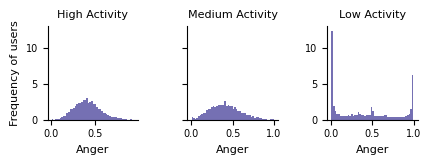

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(4.5, 1.75),
                         sharey=True
                         )

upper_users["anger"].plot.hist(ax=axs[0], 
                  bins=50, 
                  color=colors['Untrustworthy'], 
                  density=True
                  )
axs[0].set_xlabel("Anger", fontsize=8)
axs[0].set_ylabel("Frequency of users", fontsize=8)
axs[0].set_title("High Activity", fontsize=8)
axs[0].tick_params(axis='both', which='major', labelsize=7)
custom_plots(axs[0])

middle_users["anger"].plot.hist(ax=axs[1], 
                     bins=50, 
                     color=colors['Untrustworthy'], 
                     density=True
                    )
axs[1].set_xlabel("Anger", fontsize=8)
axs[1].set_title("Medium Activity", fontsize=8)
axs[1].tick_params(axis='both', which='major', labelsize=7)
custom_plots(axs[1])

lower_users["anger"].plot.hist(ax=axs[2], 
                   bins=50, 
                   color=colors['Untrustworthy'], 
                   density=True
                )
axs[2].set_xlabel("Anger", fontsize=8)
axs[2].set_title("Low Activity", fontsize=8)
axs[2].tick_params(axis='both', which='major', labelsize=7)
custom_plots(axs[2])

plt.tight_layout()
plt.show()

In [65]:
# calculate mean and std and median per group and make a table
# round anger to 2 decimals in each group
upper_users["anger"] = upper_users["anger"].round(2).copy()
middle_users["anger"] = middle_users["anger"].round(2).copy()
lower_users["anger"] = lower_users["anger"].round(2).copy()

quant_table = pd.DataFrame({
    "High activity": [upper_users["anger"].mean(), upper_users["anger"].std(), upper_users["anger"].median(), upper_users["anger"].mode()[0]],
    "Medium activity": [middle_users["anger"].mean(), middle_users["anger"].std(), middle_users["anger"].median(), middle_users["anger"].mode()[0]],
    "Low activity": [lower_users["anger"].mean(), lower_users["anger"].std(), lower_users["anger"].median(), lower_users["anger"].mode()[0]]
}, index=["Mean",
            "SD",
            "Median",
            "Mode"])
quant_table

/tmp/ipykernel_3929320/1837768542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_users["anger"] = upper_users["anger"].round(2).copy()
/tmp/ipykernel_3929320/1837768542.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_users["anger"] = middle_users["anger"].round(2).copy()
/tmp/ipykernel_3929320/1837768542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,High activity,Medium activity,Low activity
Mean,0.413412,0.408763,0.410498
SD,0.149773,0.182311,0.369474
Median,0.400000,0.400000,0.350000
Mode,0.400000,0.340000,0.000000


User groups according to Baribi-Bartov et al. (2023):
1) High activity untrustworthy: 80% of untrustworthy news replies
2) High activity trustworthy: 80% of trustworthy news replies
3) Random sample with same number of users as in group 2
4) Average activity untrustworthy: median

In [66]:
untrust_users, untrust_cutoff = def_cum_replies(misinfo_replies)
trust_users, trust_cutoff = def_cum_replies(trust_replies)
all_users, all_cutoff = def_cum_replies(replies)
untrust_users

,author_id,n_replies,cum_replies,cum_perc
0,186813764,12880,12880,3.118010
1,1373293126916395008,4644,17524,4.242236
2,3092309687,2827,20351,4.926601
3,1381276005566971904,2360,22711,5.497913
4,1360223452532244481,1847,24558,5.945038
...,...,...,...,...
32017,363067577,1,413080,99.999032
32018,1247167064139124736,1,413081,99.999274
32019,1473082761732935682,1,413082,99.999516
32020,853274242359713792,1,413083,99.999758


In [67]:
all_users.to_csv(join(DIR, "all_users_activity.csv"), index=False)

In [68]:
# keep the top 80% of users
untrust_top = untrust_users[untrust_users["cum_perc"] <= 80]
trust_top = trust_users[trust_users["cum_perc"] <= 80]
len(untrust_top), len(trust_top)

(8241, 37958)

In [69]:
size = len(trust_top)

#remove users with less than 3 replies from all_users
all_users = all_users[all_users["n_replies"] > 3]
#get a random number of rows from all_users
random_users = all_users.sample(n=size, random_state=636)
random_users

,author_id,n_replies,cum_replies,cum_perc
131601,193728922,6,10326624,95.341088
108611,1319736722272419840,9,10116996,93.405687
135485,745875671591821312,6,10302828,95.121391
171641,21292560,4,10443317,96.418462
62024,1313854575829569538,23,9464840,87.384623
...,...,...,...,...
83770,956470148730322945,14,9833925,90.792219
112330,3147218446,8,10209050,94.255580
148158,1004370966556893184,5,10349271,95.550178
84159,1362376350485602310,14,9850655,90.946680


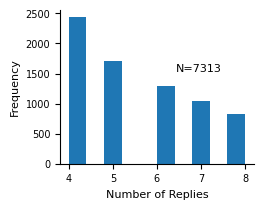

In [70]:
# what is the median activity for all misinfo users?
median = untrust_users["n_replies"].median()

# extract list of users that are more active than the median
median_untrust = untrust_users[untrust_users["n_replies"] > median]
median_untrust = untrust_users[untrust_users["n_replies"] > 3]

#remove users that are in untrust_users
avg_untrust = median_untrust[~median_untrust["author_id"].isin(untrust_top["author_id"])]

#show their distribution of replies
#figsize
plt.figure(figsize=(2.5, 2))
avg_untrust["n_replies"].plot.hist()
plt.tick_params(axis='both', which='major', labelsize=7)
plt.xlabel("Number of Replies", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.text(0.6, 0.6, f"N={len(avg_untrust)}",
         fontsize=8, transform=plt.gca().transAxes)
custom_plots()
plt.show()

In [71]:
avg_untrust

,author_id,n_replies,cum_replies,cum_perc
8776,152575687,8,330475,80.001888
8754,17572069,8,330483,80.003825
8804,589993021,8,330491,80.005762
8753,724684416996413440,8,330499,80.007698
8755,1309299433473966080,8,330507,80.009635
...,...,...,...,...
13930,1477231626841202691,4,370447,89.678371
13929,1347590546773127169,4,370451,89.679339
13926,704282873231237121,4,370455,89.680307
13927,1381288741772406785,4,370459,89.681275


In [73]:
# for each list of authors, get the tweets
untrust_tweets = misinfo_replies[misinfo_replies["author_id"].isin(untrust_top["author_id"])]
trust_tweets = trust_replies[trust_replies["author_id"].isin(trust_top["author_id"])]
random_tweets = replies[replies["author_id"].isin(random_users["author_id"])]
avg_untrust_tweets = misinfo_replies[misinfo_replies["author_id"].isin(avg_untrust["author_id"])]

# for each author, aggregate anger
untrust_agg = untrust_tweets.groupby("author_id")["anger"].mean().reset_index()
trust_agg = trust_tweets.groupby("author_id")["anger"].mean().reset_index()
random_agg = random_tweets.groupby("author_id")["anger"].mean().reset_index()
avg_untrust_agg = avg_untrust_tweets.groupby("author_id")["anger"].mean().reset_index()

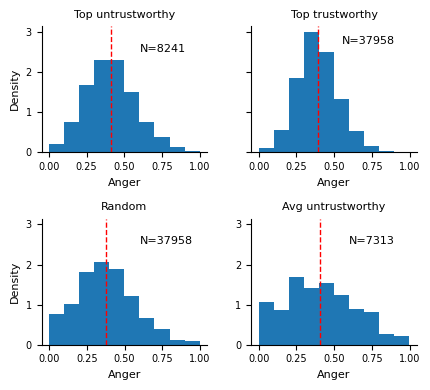

In [74]:
# plot the distribution of anger
fig, axs = plt.subplots(2, 2, figsize=(4.5, 4), 
                        sharey=True
                        )

untrust_agg["anger"].plot.hist(ax=axs[0, 0], 
                      # bins=50, 
                    #   color=colors['Untrustworthy'], 
                    density=True)
# add number of users
axs[0, 0].text(0.6, 2.5, f"N={len(untrust_agg)}",
          fontsize=8)
# add line for mean
axs[0, 0].axvline(untrust_agg["anger"].mean(), color='red', linestyle='--', linewidth=1)
axs[0, 0].set_title("Top untrustworthy",
                    fontsize=8)

trust_agg["anger"].plot.hist(ax=axs[0, 1], 
                    # bins=50, 
                    # color=colors['Trustworthy'], 
                    density=True)
axs[0, 1].text(0.55, 2.7, f"N={len(trust_agg)}",
          fontsize=8)
axs[0, 1].axvline(trust_agg["anger"].mean(), color='red', linestyle='--', linewidth=1)
axs[0, 1].set_title("Top trustworthy", 
                    fontsize=8)

random_agg["anger"].plot.hist(ax=axs[1, 0], 
                    #  bins=50, 
                    #  color="grey", 
                     density=True)
axs[1, 0].text(0.6, 2.5, f"N={len(random_agg)}",
          fontsize=8)
axs[1, 0].axvline(random_agg["anger"].mean(), color='red', linestyle='--', linewidth=1)
axs[1, 0].set_title("Random", 
                    fontsize=8)

avg_untrust_agg["anger"].plot.hist(ax=axs[1, 1], 
                          # bins=50, 
                        #   color=colors['Untrustworthy'], 
                          density=True)
axs[1, 1].text(0.6, 2.5, f"N={len(avg_untrust_agg)}",
          fontsize=8)
axs[1, 1].axvline(avg_untrust_agg["anger"].mean(), color='red', linestyle='--', linewidth=1)
axs[1, 1].set_title("Avg untrustworthy", 
                    fontsize=8)

for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xlabel("Anger", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)
    custom_plots(ax)
plt.tight_layout()
plt.show()

In [75]:
# calculate mean and std and median per group and make a table
groups_table = pd.DataFrame({
    "Untrustworthy": [untrust_agg["anger"].mean(), 
                      untrust_agg["anger"].std(), 
                      untrust_agg["anger"].median(), 
                      untrust_agg["anger"].mode()[0]],
    "Trustworthy": [trust_agg["anger"].mean(), 
                    trust_agg["anger"].std(), 
                    trust_agg["anger"].median(), 
                    trust_agg["anger"].mode()[0]],
    "Random": [random_agg["anger"].mean(), 
               random_agg["anger"].std(), 
               random_agg["anger"].median(), 
               random_agg["anger"].mode()[0]],
    "Median": [avg_untrust_agg["anger"].mean(), 
               avg_untrust_agg["anger"].std(), 
               avg_untrust_agg["anger"].median(), 
               avg_untrust_agg["anger"].mode()[0]]
}, index=["Mean",
            "SD",
            "Median",
            "Mode"])
groups_table

,Untrustworthy,Trustworthy,Random,Median
Mean,0.411163,0.391718,0.375835,0.407450
SD,0.166297,0.134700,0.192866,0.232176
Median,0.402763,0.383748,0.367595,0.397309
Mode,0.001532,0.000708,0.001532,0.001532


In [76]:
untrust_agg["group"] = "untrustworthy"
trust_agg["group"] = "trustworthy"
random_agg["group"] = "random"
avg_untrust_agg["group"] = "avg_untrustworthy"
all_anger_agg = pd.concat([untrust_agg, trust_agg, random_agg, avg_untrust_agg], axis=0)

untrust_top["group"] = "untrustworthy"
trust_top["group"] = "trustworthy"
random_users["group"] = "random"
avg_untrust["group"] = "avg_untrustworthy"
all_activity = pd.concat([untrust_top, trust_top, random_users, avg_untrust], axis=0)
all_activity = all_activity.sort_values("n_replies", ascending=False)
all_activity = all_activity.drop_duplicates(subset="author_id", keep="first")

# merge with all_anger_agg
all_activity_agg = all_activity.merge(all_anger_agg, on=["author_id", "group"], how="left")
all_activity_agg

/tmp/ipykernel_3929320/402468163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  untrust_top["group"] = "untrustworthy"
/tmp/ipykernel_3929320/402468163.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trust_top["group"] = "trustworthy"
/tmp/ipykernel_3929320/402468163.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,author_id,n_replies,cum_replies,cum_perc,group,anger
0,1367862514579542017,15295,15295,0.146781,trustworthy,0.001581
1,709433267297107968,14758,30053,0.288408,trustworthy,0.260810
2,186813764,13777,43909,0.405392,random,0.350980
3,1267192643831947265,12644,42697,0.409748,trustworthy,0.015462
4,1346043407286861824,9986,52683,0.505580,trustworthy,0.320817
...,...,...,...,...,...,...
71239,1415833896390905859,4,10441937,96.405722,random,0.393047
71240,16024541,4,10492281,96.870525,random,0.503782
71241,10970952,4,10418157,96.186171,random,0.653709
71242,1135825327090020352,4,10435217,96.343679,random,0.030353


In [77]:
trust_group = all_activity_agg[all_activity_agg["group"] == "trustworthy"]
random_activity = all_activity_agg[all_activity_agg["group"] == "random"]
random_activity = random_activity.sample(n=len(trust_group), random_state=636)

all_activity_agg = pd.concat([all_activity_agg[all_activity_agg["group"] != "random"], 
                              random_activity], axis=0)

all_activity_agg.group.value_counts()

trustworthy          31512
random               31512
avg_untrustworthy     2497
untrustworthy         1341
Name: group, dtype: int64

In [78]:
# rename colum nanme
all_activity_agg = all_activity_agg.rename(columns={"anger": "anger_user"})
all_activity_agg["author_id"].nunique()

66862

In [79]:
# filter out the tweets that are in the all_agg["author_id"]
group_users_tweets = all_activity_agg[["author_id", "group", "anger_user"]]\
                        .merge(replies[["conversation_id", "author_id", "anger"]],
                                on="author_id",
                                how="left")\
                        .merge(starter[["id", "Rating"]],
                                    left_on="conversation_id",
                                    right_on="id",
                                    how="left")
len(group_users_tweets), len(all_activity_agg) #(8988826, 84054)

(8978052, 66862)

In [80]:
group_users_tweets.group.unique()

array(['trustworthy', 'untrustworthy', 'avg_untrustworthy', 'random'],
      dtype=object)

In [81]:
all_activity_agg['group'] = pd.Categorical(
    all_activity_agg['group'],
    categories=['random', 'trustworthy', 'untrustworthy', 'avg_untrustworthy'],
    ordered=True
)

model = smf.ols("anger_user ~ group", data=all_activity_agg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             anger_user   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     108.6
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           3.68e-70
Time:                        14:09:36   Log-Likelihood:                 23001.
No. Observations:               66862   AIC:                        -4.599e+04
Df Residuals:                   66858   BIC:                        -4.596e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3760      0.001    389.113      0.000       0.374       0.378
group[T.trustworthy]           0.0148      0.001     10.807      0.000       0.012       0.017
group[T.untrustworthy]         0.0507      0.005     10.593      0.000       0.041       0.060
group[T.avg_untrustworthy]     0.0475      0.004     13.315      0.000       0.040       0.054
==============================================================================
Omnibus:                     1253.569   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1380.622
Skew:                           0.310   Prob(JB):                    1.59e-300
Kurtosis:                       3.332   Cond. No.                         8.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
# run a regression model with anger as dependent variable
# and group as independent variable
group_users_tweets['group'] = pd.Categorical(
    group_users_tweets['group'],
    categories=['random', 'trustworthy', 'untrustworthy', 'avg_untrustworthy'],
    ordered=True
)

model = smf.ols("anger ~ group", data=group_users_tweets).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  anger   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     173.3
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          2.31e-112
Time:                        14:10:03   Log-Likelihood:            -5.2708e+06
No. Observations:             8978052   AIC:                         1.054e+07
Df Residuals:                 8978048   BIC:                         1.054e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3963      0.000   1213.021      0.000       0.396       0.397
group[T.trustworthy]           0.0011      0.000      2.880      0.004       0.000       0.002
group[T.untrustworthy]         0.0207      0.001     15.279      0.000       0.018       0.023
group[T.avg_untrustworthy]     0.0319      0.002     17.294      0.000       0.028       0.036
==============================================================================
Omnibus:                 39557926.063   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1316744.910
Skew:                           0.415   Prob(JB):                         0.00
Kurtosis:                       1.318   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
# extract the coefficients and save them for plotting
coefs = model.params
lower_ci = model.conf_int()[0]
upper_ci = model.conf_int()[1]

In [84]:
predictions = model.predict(group_users_tweets)
residuals = model.resid

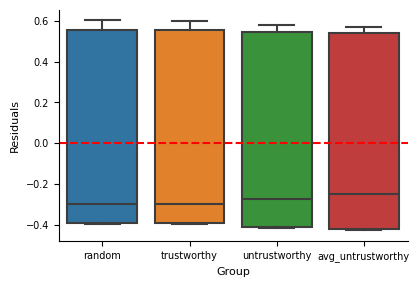

In [85]:
group_users_tweets["residuals"] = residuals

plt.figure(figsize=(4.5, 3))
sns.boxplot(x="group", y="residuals", data=group_users_tweets)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Group", fontsize=8)
plt.ylabel("Residuals", fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)
custom_plots()
plt.show()

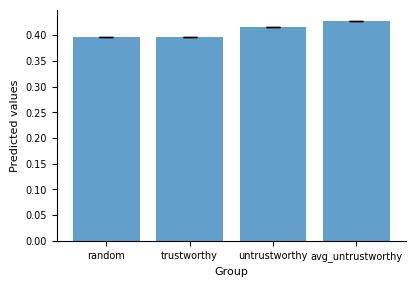

In [86]:
group_users_tweets["predicted"] = predictions

group_pred_stats = group_users_tweets.groupby("group")["predicted"].agg(["mean", "std", "count"]).reset_index()
group_pred_stats["sem"] = group_pred_stats["std"] / group_pred_stats["count"] ** 0.5 

plt.figure(figsize=(4.5, 3))
plt.bar(group_pred_stats["group"], group_pred_stats["mean"], yerr=group_pred_stats["sem"], capsize=5, alpha=0.7)
plt.xlabel("Group", fontsize=8)
plt.ylabel("Predicted values", fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)
custom_plots()
plt.show()

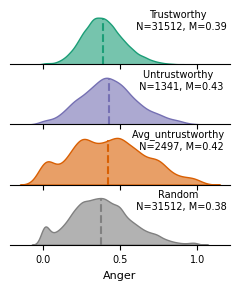

In [87]:
group_colors = {"trustworthy": "#1b9e77", 
                "untrustworthy": "#7570b3", 
                "avg_untrustworthy": "#d95f02",
                "random": "grey"}
group_labels = list(group_colors.keys())

fig, axes = plt.subplots(
    len(group_labels), 1, 
    figsize=(2.5, 3), 
    sharex=True)

for i, (group, color) in enumerate(group_colors.items()):
    group_data = all_activity_agg[all_activity_agg['group'] == group]['anger_user']  
    avg_value = group_data.mean()  


    kde = gaussian_kde(group_data)
    x_vals = np.linspace(group_data.min(), group_data.max(), 1000)
    density_vals = kde(x_vals)

    sns.kdeplot(group_data, color=color, ax=axes[i], fill=True, alpha=0.6)

    # Find the height of the density curve at the mean
    density_at_mean = kde(avg_value)

    axes[i].vlines(
        avg_value, 
        ymin=0, 
        ymax=density_at_mean, 
        color=color, 
        linestyle="--", 
        linewidth=1.5
    )
    
    axes[i].set_title(
        f"{group.capitalize()} \n N={len(group_data)}, M={avg_value:.2f}", 
            fontsize=7,
            x=0.77,
            y=0.55)
    axes[i].set_ylabel("", fontsize=10)
    custom_plots(axes[i])
    axes[i].set_yticks([])
    axes[i].set_yticklabels([])
    axes[i].spines['left'].set_visible(False)


axes[-1].set_xlabel("Anger", fontsize=8)
axes[-1].tick_params(axis='both', which='major', labelsize=7)

plt.tight_layout(w_pad=0, h_pad=0) 

plt.savefig(join(PAPER_DIR, "figures", "anger_user_groups.pdf"), dpi=300)

plt.show()

In [88]:
# save the data as csv
all_activity_agg.to_csv(join(DIR, "user_activity_agg.csv"), index=False)